## Johnson Wei (004150718)
## CS 5190 SPR20 : Assignment 1

### <u>INSTRUCTIONS</u>: The image file will be provided within *johnsonwei_assignment1.zip
### so that the viewer can set their own relative path. The string path within the imread function
### needs to be modified.
```python 
    img = cv2.imread('/change/this/to/your/path', 0)
```

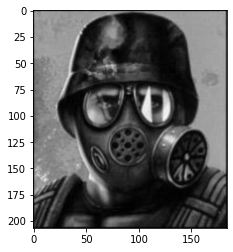

In [116]:
import numpy as np
import cv2 # to test our implemented functions with the library
from matplotlib import pyplot as plt # to plot our images

# View our image file that we will be working on
img = cv2.imread('/Users/johnsonFreemanClarke/Pictures/aShephard.jpg', 0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

### <u>Image Histogram</u>
### Part (1a)
### Implement my own version of a histogram equalization function from scratch.

Text(0.5, 1.0, 'Shape of Histogram')

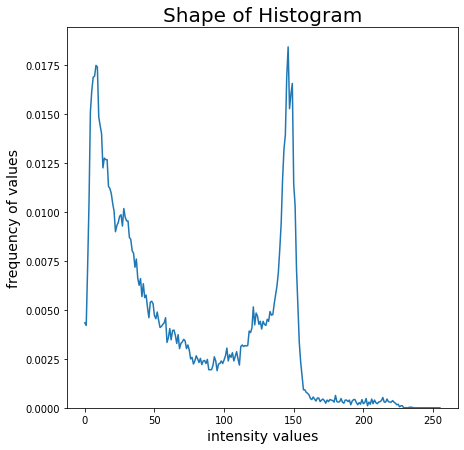

In [117]:
# First we need to gather the relevant data to construct our histogram. 
# The following work here constructs a histogram to show that it's not equalized. 
# This will be the histogram before it goes through equalization.

intensity_counts = [] # create a list to store all intensity values
for i in range(256):
    intensity_counts.append(np.count_nonzero(img == i))

# for plotting purposes, we need the x-axis to be labeled from 0-255
intensity_values = []
for i in range(256):
    intensity_values.append(i)

# We make an adjustment to show the frequency values of the Y axis
import copy

# we need to get the frequency of counts and have the y axis represent the percentage of pixels
frequency_of_values = copy.deepcopy(intensity_counts)
for i in range(256):
    frequency_of_values[i] = frequency_of_values[i]/img.size # img.size is total pixels

# now we plot the graph with the y-axis representating the frequency of values 
plt.figure(figsize = (7,7)) # adjust the size of graph
plt.ylim([min(frequency_of_values),max(frequency_of_values) + 0.001]) # 0.001 gives more room above y maximum value
plt.plot(intensity_values, frequency_of_values)
plt.xlabel('intensity values', fontsize = 14)
plt.ylabel('frequency of values', fontsize = 14)
plt.title('Shape of Histogram', fontsize = 20)

In [118]:
# Creating histogram function for verification
def createHistogram(image, bin_count):
    # fill array with all bins equal to zero
    hist_flat_array = np.zeros(bin_count)
    
    for pixel in image:
        hist_flat_array[pixel] += 1 # add a count
    return hist_flat_array

# To equalize our histograms, we need to create a cumulative sum function
def getCumulativeSum(histogram):
    histogram = iter(histogram) # creating an iterator of histogram
    cumulative_sum = [next(histogram)]
    for index in histogram:
        cumulative_sum.append(cumulative_sum[-1] + index) # we're taking the last previous value and adding it to the next entry of our cumulative _sum
    return np.array(cumulative_sum)

In [119]:
# My implementation of the equalizeHist function
def myEqualizeHist(image):
    # I convert my image to a numpy array for easier processing
    image = np.asarray(image)
    
    # by flattening our image, we can process the intensity values using less for loops
    flat_img_array = image.flatten()
    
    # create a histogram
    histogram = createHistogram(flat_img_array, 256)
    
    # execute the cumulative sum function
    cumulative_sum = getCumulativeSum(histogram)
    
    # In order to normalize the cumulative sum values to be between 0 and 255
    # we will get the total sum and divide that by the normalize_constant
    total_sum = (cumulative_sum - cumulative_sum.min()) * 255 # cumulative_sum.min() represents c_0 in our lecture notes
    normalize_constant = cumulative_sum.max() - cumulative_sum.min()

    # Normalizing the cumulative distribution
    cumulative_sum = total_sum / normalize_constant

    # we are working with image intensity values so we assign data type uint8
    cumulative_sum = cumulative_sum.astype('uint8')
    
    # Let our updated image represent the new cumulative distribution
    updated_img = cumulative_sum[flat_img_array]
    
    # This allows us to reformat the updated_img into a 2D array so that we can project a picture
    updated_img = np.reshape(updated_img, img.shape)
    
    return updated_img # an image that has been histogram equalized

In [120]:
# Creating a function to display images side by side so that we can visually compare the two.
# Result: image1 and image2 will displayed left to right, respectively.
def postPicsSideBySide(image1, image2):
    pic = plt.figure()
    pic.set_figheight(7)
    pic.set_figwidth(7)
    pic.add_subplot(1,2,1)
    plt.imshow(image1, cmap='gray')

    # add image2
    pic.add_subplot(1,2,2)
    plt.imshow(image2, cmap='gray')

    plt.show()

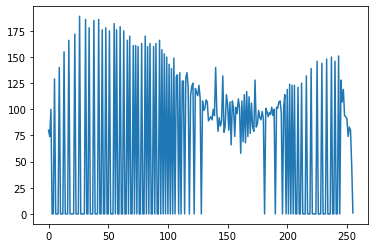

In [121]:
# We see a more uniformly equalized histogram here compared to the original histogram below
equalized_histogram = createHistogram(updated_img, 256)
plt.plot(equalized_histogram)

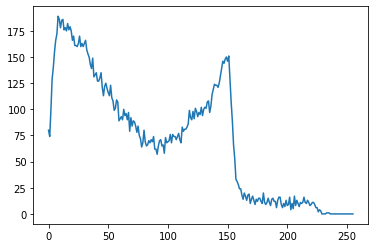

In [122]:
# Original histogram from original image
original_img = np.asarray(img)
histogram = createHistogram(original_img, 256)
plt.plot(histogram)

### Part (1b)
### Perform my function on an image and compare the result with that of the openCV equalizeHist function.
### Original image is shown first (left) compared to its equalized version (right)

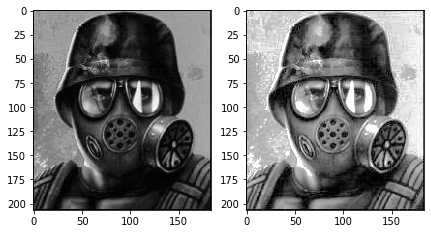

In [123]:
# Result of running my implemented function
myImage = myEqualizeHist(img)
postPicsSideBySide(img, myImage)

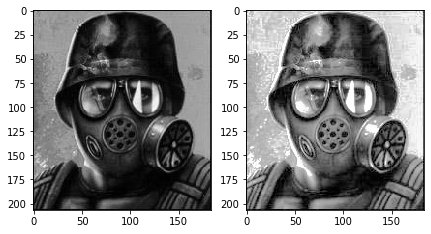

In [124]:
# Result of running cv2.equalizeHist function
equ = cv2.equalizeHist(img)
postPicsSideBySide(img, equ)

### Alternatively, if you want to use cv2 to view the images separately then please uncomment the following
### lines below. The last line consists of waitKey(1) to accommodate for viewing on mac OSX.
```python
 cv2.imshow('image comparison', res)
 cv2.waitKey(0)
 cv2.destroyAllWindows()
 cv2.waitKey(1)
```

### <u>Image Smoothing</u>
### Part (2a)
### Implement my own Gaussian smoothing function from scratch.
I've created a lot of helper functions in the beginning that will assist in creating a Gaussian-blurred
image.

In [125]:
# Purpose: to find the origin of a given kernel
# returns the center coordinates (tuple) of given numpy array
# kernel must be m x n, where m & n are odd
def getOrigin(kernel):
    x = kernel.shape[0]
    y = kernel.shape[1]
    if (x % 2 == 1) and (y % 2 == 1): # checking for rows and cols to be of odd quantity
        myTuple = (kernel.shape[0]//2, kernel.shape[1]//2) # floor division
        return myTuple
    print('kernel must have odd # of rows and cols!')
    myTuple = ()
    return myTuple

In [126]:
# Purpose: pad an image with a black border relative to the origin of a kernel
# for the use of Gaussian filtering  
def padImage(image, kernel_origin):
    # convert image to numpy array
    new_image = np.asarray(image).copy() # to be able to make use of np.vstack and np.hstack
    
    # kernel: (x,y)
    # x value will determine the # of top and bottom rows to stack
    x = kernel_origin[0]
    rows = np.zeros((x, new_image.shape[1]), dtype=np.uintc)
    
    # vertically stack the new rows onto top & bottom of new_image array
    new_image = np.vstack([rows, new_image])
    new_image = np.vstack([new_image, rows])
    
    # y value will determine the # of left and right cols to place
    y = kernel_origin[1]
    cols = np.zeros((new_image.shape[0], y), dtype=np.uintc)
    
    # horizontally stack the new cols onto left & right of new_image array
    new_image = np.hstack([cols, new_image])
    new_image = np.hstack([new_image, cols])
    
    return new_image

In [127]:
# Purpose: Convert kernel to contain proper coordinates for use of SOP
# helps with the visualization process of kernel coordinates
# conditions: kernel indexes must contain tuple indicating location
# results: will return a kernel with Gaussian filter coordinates
def applyKernelCoords(kernel):
    origin = getOrigin(kernel)
    x_origin = origin[0] * -1 # applying negatives to the origin values to match the filter-kernel mapping
    y_origin = origin[1] * -1
    updated_kernel = np.zeros((kernel.shape[0], kernel.shape[1]), dtype=tuple)
    for row in range(kernel.shape[0]):
        for col in range(kernel.shape[1]):
            updated_kernel[row, col] = ((row + x_origin), (col + y_origin))
    return updated_kernel

In [128]:
import math
# Purpose: Apply the gaussian forumla to each index of a matrix
# isKernel: determines if we're operating on Kernel or ROI image matrix
def getGaussianForRegion(roi_matrix, sigma, isKernel):
    updated_matrix = np.zeros((roi_matrix.shape[0], roi_matrix.shape[1]), dtype=np.float32)
    kernel_coords = applyKernelCoords(roi_matrix) # we will need this in case isKernel == False
    for row in range(roi_matrix.shape[0]):
        for col in range(roi_matrix.shape[1]):
            s = kernel_coords[row, col][0]
            t = kernel_coords[row, col][1]
            if isKernel:
                gaussian = math.e**-((s**2 + t**2)/(2 * sigma**2))
                updated_matrix[row, col] = gaussian
            else: # if roi_matrix is not a kernel matrix
                x = roi_matrix[row, col]
                y = x # (x, y) is the pixel's intensity value
                gaussian = x
                updated_matrix[row, col] = gaussian
    return updated_matrix

In [129]:
# Purpose: need to sum entire updated kernel to get value of K: the normalizing constant
def getK(gaussian_kernel):
    K = np.sum(gaussian_kernel)
    return (1/K)

In [130]:
# Purpose: we will need to apply the K to the Gaussian kernel in order to normalize it
# K represents the normalization constant
def normalizeMatrix(matrix, K):
    normalized_kernel = matrix.copy()
    for row in range(normalized_kernel.shape[0]):
        for col in range(normalized_kernel.shape[1]):
            normalized_kernel[row, col] *= K
    return normalized_kernel

In [131]:
# Purpose: compute the SOP of two matrices with the same shape
# Conditions: matrix_a and matrix_b are (mxn) where m & n are odd positive integers
def getSumOfProducts(matrix_a, matrix_b):
    if matrix_a.shape != matrix_b.shape:
        print('function: getSumOfProducts(matrix_a, matrix_b)\n')
        print('kernel matrices must have same shape!')
    sop_value = 0
    for row in range(matrix_a.shape[0]):
        for col in range(matrix_a.shape[1]):
            sop_value += matrix_a[row, col] * matrix_b[row, col]
    return sop_value

In [132]:
# My implementation of the GaussianBlur function
# image - represents an image
# filter_size - a tuple representing the size (row, column)
# sigma - to be decided by the user
def getFilteredImage(image, filter_size, sigma):
    # if image is not a dtype=(np.darray), convert it into one
    if type(image) != np.ndarray:
        image = np.asarray(image, dtype=np.uint8)

    # create the kernel
    kernel = np.zeros((filter_size[0], filter_size[1]), dtype=np.float32)
    
    # convert the kernel to have gaussian coords
    kernel_coord_map = applyKernelCoords(kernel)

    # apply the gaussian formula to each individual coord 
    kernel = getGaussianForRegion(kernel_coord_map, sigma, True) # True indicates that we're working with a kernel
    
    # derive K from the gaussian_kernel
    K = getK(kernel)
    
    # normalize the gaussian_kernel with constant K
    kernel = normalizeMatrix(kernel, K)

    # Make a copy of the image so that we can adjust its pixel values without affecting the (original) image
    filtered_image = image.copy()
    
    # we also need to pad the image with respect to the kernel dimensions
    padded_image = image.copy()
    padded_image = padImage(padded_image, getOrigin(kernel))
    
    # prepare for moving average computation here (refer to SOP convolution equation)
    # we will take the sum of this matrix after computation to add onto filtered_image's pixel
    sop_matrix = np.zeros((filter_size[0], filter_size[1]), dtype=np.float32)
    
    # Run the moving averages loop here and compute the SOP
    # we will get the difference of rows and columns between the gaussian_kernel and padded_image
    rows = padded_image.shape[0] - kernel.shape[0]
    cols = padded_image.shape[1] - kernel.shape[1]
    
    # We want to complete the sum of products (convolution) between kernel and original image
    # in a moving averages fashion
    for i in range(rows+1): # +1 takes care of the offset 
        for j in range(cols+1):
            # save a slice of the padded_image to do SOP with kernel
            partial_image = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]].copy()
            # apply gaussian formula to partial_image, False lets us know that we are not dealing with a kernel
            partial_image = getGaussianForRegion(partial_image, sigma, False)
            
            # get SOP and apply it to the filtered_image
            filtered_image[i, j] = getSumOfProducts(kernel, partial_image) 
    return filtered_image

### Part (2b)
### Compare my result with the openCV GaussianBlur function.

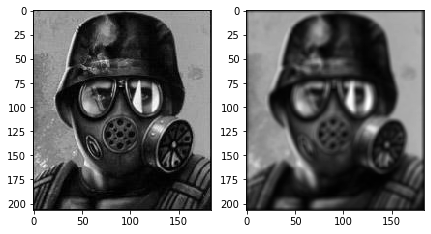

In [133]:
# Test my implemented function of the Gaussian Blur with the following parameters
# Original img (left), blurred image (right)
filter_size = (5,5) # (m, n) must be odd values
sigma = 3
filterImage = getFilteredImage(img, filter_size, sigma)

postPicsSideBySide(img, filterImage)

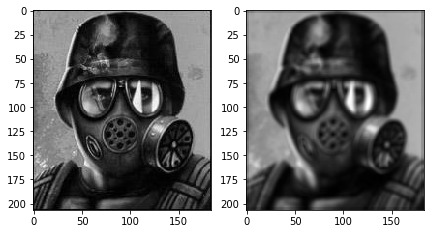

In [134]:
# Using the cv2 Gaussian Blur function
blur = cv2.GaussianBlur(img, filter_size, sigma)
postPicsSideBySide(img, blur)

My resultant image array

In [135]:
print(filterImage)

[[ 26  40  51 ...  57  44  28]
 [ 40  61  78 ...  85  65  42]
 [ 54  81 104 ... 110  84  54]
 ...
 [ 20  26  31 ...  11   9   5]
 [ 15  19  23 ...   8   7   4]
 [ 10  12  15 ...   6   5   3]]


cv2's resultant image array

In [136]:
print(blur)

[[ 94  96  98 ... 108 104 103]
 [ 98  99 100 ... 109 105 104]
 [103 103 105 ... 112 107 106]
 ...
 [ 40  35  32 ...  11  11  11]
 [ 37  32  30 ...  11  11  11]
 [ 37  33  30 ...  12  12  12]]


## <u>Conclusion</u>: 
In terms of visual display, we hardly notice a difference, but upon inspecting the image intensities of the image arrays, we can see subtle differences.